## 5.1 야후 파이낸스와 네이버 금융 비교

### 5.1.1 야후 파이낸스 데이터의 문제점
- 야후 파이낸스 주식 데이터 문제점 확인해보자.

[*********************100%***********************]  1 of 1 completed


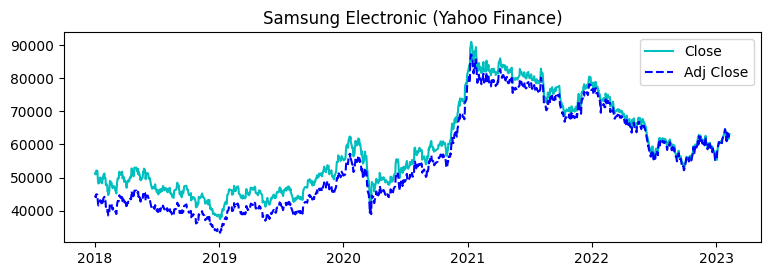

In [4]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt

df = pdr.get_data_yahoo('005930.KS', '2018-01-01')

plt.figure(figsize=(9, 6))
plt.subplot(2,1,1)
plt.title('Samsung Electronic (Yahoo Finance)')
plt.plot(df.index, df['Close'], 'c', label='Close')
plt.plot(df.index, df['Adj Close'], 'b--', label = 'Adj Close')
plt.legend(loc='best')
plt.show()

- 야후 파이낸스 주식 데이터가 사용하기 편리하지만, 그래프로 출력해서 유심히 살펴보면 다음과 같은 문제점 발견.
1) 한국 주식 종목들의 데이터는 종가 및 수정 종가가 정확하지 않다.
2) 한국 주식 종목들은 2017년 10월에 3주 가량의 데이터가 비었다.

### 5.1.2 네이버 금융 데이터로 시세 데이터베이스 구축하기
- 시세 조회 API는 Inverstar 패키지의 Analyzer 모듈에 포함되어 있으며, MarketDB 클래스의 get_daily_price() 메서드다.


### 5.2.3 헤이디에스큐엘
- 마리아와 함께 설치된 그래픽 사용자 인터페이스 기반
- 간편하게 데이터 조회 수정, 프로시져, 트리거, 이벤트 등 쉽게 관리


### 5.2.4 파이마이에스큐엘로 버전 정보 확인하기

- pymysql을 설치하면 파이썬 내부에서 커서(cursor) 객체를 생성하여 SQL문을 실행할 수 있다.
- pymysql의 connection 객체의 autocommit 속성은 기본적으로 False이기 때문에 INSERT, UPDATE, DELETE 문으로 데이터를 변경하더라도 connection.commit() 함수를 호출해야 실제로 데이터베이스에 반영된다.
- 이때 commit() 함수는 커서 객체가 아닌 커넥션 객체에서 호출해야 된다는 점에 유의하자.
- 만일 아래 예제처럼 connect() 함수를 호출할 때 autocommit 인수를 true로 설정해주면 별도로 commit() 함수를 호출하지 않아도 SQL문의 실행 결과가 데이터베이스에 반영된다.

In [5]:
import pymysql
connection = pymysql.connect(host = 'localhost', port = 3306, db='INVESTAR', user='root',
passwd='ghdtnsduf1', autocommit=True)

cursor = connection.cursor()
cursor.execute('SELECT VERSION();')
result = cursor.fetchone()

print('MariaDB version : {}'.format(result))

connection.close()

MariaDB version : ('10.10.3-MariaDB',)


1. connect() 함수를 사용해 connection 객체 생성.
2. cursor() 함수를 사용해 cursor 객체 생성
3. cursor 객체의 execute() 함수를 사용해 select문 실행
4. cursor 객체의 fetchone() 함수를 사용해 실행 결과를 튜플로 받기

## 5.3 주식 시세를 매일 DB로 업데이트하기
- 네이버 금융의 주식 시세를 뷰티풀 수프와 팬더스로 읽어와서 마리아디비에 매일 자동으로 업데이트 해주는 DBUpdater 모듈 생성
- 자동 분석 시스템을 운영하려면 데이터베이스를 구축하는 것이 안정적이고 편리하다.

### 5.3.1 DBUpdater 클래스 구조
- DBUpdater.py에 생성

### 5.3.2 헤이디에스큐엘로 테이블 생성하기
- 먼저 Investar 데이터베이스에 회사명과 종목코드를 저장할 company_info 테이블과 주식 시세를 저장할 daily_price 테이블을 생성하자.

### 5.3.3 복합 기본키
- 하나의 컬럼이 아닌 둘 이상의 컬럼을 묶어서 기본키로 사용할 경우 복합 기본키라고 한다.
- 기본키에는 자동으로 색인이 설정되므로 code와 date 칼럼을 이용하여 데이터를 조회하면 다른 칼럼으로 조회할 때보다 훨씬 빠르다.

### 5.3.4 파이마이에스큐엘로 테이블 생성하기
- pymysql 라이브러리를 이용하여 파이썬 프로그램에서 직접 SQL 구문을 실행할 수 있다.
- 다음은 매일 일정한 시간에 네이버 금융 데이터를 웹 스크레이핑해서 마리아디비에 업데이트하는 DBUpdater 클래스다.

### 5.3.5 종목코드 구하기
- 한국거래소 사이트에서 제공하는 '상장법인목록.xls 파일'을 다운로드해 문자열로 변경하는 코드.

In [6]:
import pandas as pd
class DBUpdater:
    def read_krx_code(self):
        '''KRX로부터 상장기업 목록 파일을 읽어와서 데이터프레임으로 반환'''
        url = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13'
        krx = pd.read_html(url, header=0)[0]
        krx = krx[['종목코드', '회사명']]
        krx = krx.rename(columns = {'종목코드':'code','회사명':'company'})

        krx.code = krx.code.map('{:06d}'.format)
        return krx

### 5.3.6 종목코드를 DB에 업데이트하기
- KRX 사이트로부터 종목코드 리스트를 읽어오는데 다소 시간이 걸리므로, 하루에 한번만 읽어서 업데이트.
- company_info 테이블에 last_update 컬럼을 조회하여 오늘 날짜로 업데이트 한 기록이 있으면 더는 업데이트 하지 않도록

REPLACFE INTO 구문
- INSERT INTO 구문 역시 데이터 행이 테이블에 이미 존재하면 오류 발생.
- 마리아디비에서 제공하는 REPLACE INTO 구문을 사용하면, 동일한 데이터 행이 존재하더라도 오류를 발생하지 않고 UPDATE를 수행.
- REPLACE INTO 구문처럼 INSERT와 UPDATE를 합쳐놓은 기능을 UPSERT라고 한다.

In [7]:
from datetime import datetime

class DBUpdater:
    def update_comp_info(self):
        '''종목코드를 company_info테이블에 업데이트한 후 딕셔너리에 저장'''
        sql = 'select * from company_info'
        df = pd.read_sql(sql, self.conn)
        for idx in range(len(df)):
            self.codes[df['code'].values[idx]]=df['company'].values[idx]
        with self.conn.cursor() as curs:
            sql = 'select max(last_update) from company_info'
            curs.execute(sql)
            rs = curs.fetchone()
            today = datetime.today().strftime('%Y-%m-%d')

            if rs[0]==None or rs[0].strftime('%Y-%m-%d') < today:
                krx = self.read_krx_code()
                for idx in range(len(krx)):
                    code = krx.code.values[idx]
                    company = krx.company.values[idx]

                    sql = f"replace into company_info (code, company, last_update) values ('{code}', '{company}', '{today}')"
                    curs.execute(sql)
                    self.codes[code] = company
                    tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
                    print(f"[{tmnow}] {idx:04d} replace into company_info values({code}, {company}, {today})")
                self.conn.commit()
                print('')

### 5.3.7 주식 시세 데이터 읽어오기
- KRX 종목코드를 DB에 업데이트했으므로 이제 네이버 금융으로부터 모든 종목의 일별 시세 데이터 스크레이핑
- 다만 pgRR 클래스의 <td> 태그가 존재하지 않으면 AttributeError가 발생하면서 프로그램이 종료되므로, find함수 결과가 None인 경우에는 다음 종목을 처리.
- read_html() 함수로 주식 시세 페이지를 일거올 때도 HTTP Error가 발생하면서 프로그램이 종료될 수 있으므로, try except구문으로 예외처리할 필요가 있다.

In [12]:
import requests
from bs4 import BeautifulSoup

def read_naver(self, code, company, pages_to_fetch):
    '''네이버에서 주식 시세를 읽어서 데이터프레임으로 반환'''
    try:
        url = f"http//finance.naver.com/item/sise_day.nhn?code={code}"
        html = requests.get(url, headers = {'User-agent':'Mozilla/5.0'}).text
        bs = BeautifulSoup(html, 'lxml')
        pgrr = bs.find('td', class_='pgRR')
        if pgrr is None:
            return None
        s = str(pgrr.a['href']).split('=')
        lastpage = s[-1]
        df = pd.DataFrame()
        pages = min(int(lastpage), pages_to_fetch)
        for page in range(1, pages+1):
            url = '{}&page={}'.format(url, page)
            req = requests.get(u, headers={'User-agent': 'Mozilla/5.0'})
            df = df.append(pd.read_html(req.text, header=0)[0])
            tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
            print('[{}] {} ({}) : {:04d}/{:04d} pages are downloading...'.format(tmnow, company, code, page, pages), end='\r')
        df = df.rename(columns = {'날짜':'date', '종가':'close', '전일비':
        'diff', '시가':'open', '고가':'high', '저가':'low', '거래량':'volumne'})
        df['date'] = df['date'].replace('.','-')
        df = df.dropna()
        df[['close', 'diff', 'open',' high', 'low', 'volume']] = df[['close', 'diff', 'open',' high', 'low', 'volume']].astype(int)
        df = df[['date', 'open','jigj', 'low', 'close', 'diff', 'volume']]
    except Exception as e:
        print('Exception occured :',str(e))
        return None
    return df

### 5.3.8 일별 시세 데이터를 DB에 저장하기
- read_naver() 메서드로 읽어온 네이버 일별 시세를 DB에 저장하는 replace_into_db 메서드.

In [13]:
def replace_into_db(self, df, num, code, company):
    '''네이버에서 일겅온 주식 시세를 DB에 REPLACE'''
    with self.conn.cursor() as curs:
        for r in df.itertuples():
            sql = f"replace into daily_price values ('{code}' ,'{r.date}', {r.open}, {r.high}, {r.low}, {r.close}, {r.diff}, {r.volumne})"
            curs.execute(sql)
        self.conn.commit()
        print('[{}] #{:04d} {} ({}) : {} rows > REPLACE INTO daily_price [OK]'.format(datetime.now().strftime('%Y-%m-%d %H:%M'), num+1, company, code, len(df)))

In [14]:
def update_daily_price(self, pages_to_fetch):
    '''KRX 상장법인의 주식 시세를 네이버로부터 읽어서 DB에 업데이트'''
    for idx, code in enumerate(self.codes):
        df = self.read_naver(code, self.codes[code], pages_to_fetch)
        if df is None:
            continue
        self.replace_into_db(df, idx, code, self.codes[code])

### 5.3.9 json을 이용한 업데이트 페이지 수 설정
- config.json 파일을 이용해 DBUpdater가 처음 실행되었는지 여부 체크.


In [1]:
import json
import calendar
import time
from threading import Timer

def execute_daily(self):
    '''실행 즉시 및 매일 오후 다섯시에 daily_price 테이블 업데이트'''
    self.update_comp_info()
    try:
        with open('config.json', 'r') as in_file:
            config = json.load(in_file)
            pages_to_fetch = config['pages_to_fetch']
    except FileNotFoundError:
        with open('config.json', 'w') as out_file:
            pages_to_featch = 100
            config = {'pages_to_fetch':1}
            json.dump(config, out_file)
    self.update_daily_price(pages_to_fetch)

    tmnow = datetime.now()
    lastday = calendar.monthrange(tmnow.year, tmnow.month)[1]
    if tmnow.month ==12 and tmnow.day ==lastday:
        tmnext = tmnow.replace(year= tmnow.year+1, month=1, day=1,
        hour= 17, minute=0, second = 0)
    elif tmnow.day == lastday:
        tmnext = tmnow.replace(month = tmnow.month+1, day=1, hour=17, minute = 0, second = 0)

    else:
        tmnext = tmnow.replace(day=tmnow.day+1, hour = 17, minute=0, second = 0)

    tmdiff = tmnext - tmnow
    secs = tmdiff.seconds

    t = Timer(secs, self.execute_daily)
    print('Waiting for next update ({}) ...'.format(tmnext,strftime('%Y-%m-%d %H: %M')))
    t.start()